# Class Notebooks

* [HAPI_00.ipynb](HAPI_00.ipynb) - Introduction
* **[HAPI_01.ipynb](HAPI_01.ipynb) - Basics (this Notebook)**
* [HAPI_02.ipynb](HAPI_02.ipynb) - Data structures
* [HAPI_03.ipynb](HAPI_03.ipynb) - Plotting
* [HAPI_04.ipynb](HAPI_04.ipynb) - Problems

# Setup

We'll be using data from the October 28, 2021 flare + CME event that started at 15:35 UTC.

First, we will import the HAPI libraries.  We'll repeat these calls in each example so that you can try them in any order during this demo.  The basic import lines can be used in any Python code. 

In [ ]:
from hapiclient import hapi
from hapiplot import hapiplot

The following are optional Jupyter Notebook-specific configuration options

In [2]:
# Show Matplotlib plots in page instead of opening a window
%matplotlib inline 
# Have Matplotlib create vector (svg) instead of raster (png) images
%config InlineBackend.figure_formats = ['svg']

# Misc. configuration
import warnings
# See https://github.com/boto/boto3/issues/454 for an explanation of suppressed warning.
warnings.simplefilter("ignore", ResourceWarning)

# Display documentation

The function [`hapi`](https://github.com/hapi-server/client-python/blob/master/hapiclient/hapi.py#L144) is the primary function that you will use. Note that it does not follow common Python conventions for function calls because the number of non-keyword arguments is not fixed and the number of outputs varies depending on the input arguments.

In [ ]:
from hapiclient import hapi
help(hapi)

The other two functions that you will use are [`hapitime2datetime`](https://github.com/hapi-server/client-python/blob/master/hapiclient/hapitime.py#L158) and [`hapiplot`](https://github.com/hapi-server/plot-python/blob/main/hapiplot/hapiplot.py#L17).

In [ ]:
from hapiclient import hapitime2datetime
help(hapitime2datetime)

In [ ]:
from hapiplot import hapiplot
help(hapiplot)

# Get Data

The event started at 15:35 UTC on Oct 28, 2021 with a [X1 Flare](https://www.spaceweatherlive.com/en/news/view/445/20211028-x1-solar-flare-with-a-major-cme.html) and an accompanying coronal mass ejection (CME). The CME was predicted to arrive [at Earth on Oct 30](https://www.swpc.noaa.gov/news/geomagnetic-storm-watch-effect-30-31-oct) and induce activity through Oct 31.  We will look at data fetched via HAPI for before, during, and after this event and see what patterns arise.

## Example 1: OMNIWeb Solar Wind via CDAWeb

We will start by using HAPI to fetch the Dst index from the OMNIWeb (parameter name is `DST1800`) dataset and `Proton_AI1800` (Solar wind mag density/kinetic energy density), plus metadata, for Oct 25 through Dec 5.  

For this first example, `logging=True` is used so that you can see the steps that `hapi` is (or is not) taking; for production use, or to de-clutter the screen, you likely will choose to turn this off with `logging=False` (the default).

_Note: `hapi` returns `data` as a NumPy `ndarray` and `meta` as a Python dict_

In [ ]:
## OMNIWeb data
from hapiclient import hapi

# The data server
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'

# The data set
dataset    = 'OMNI2_H0_MRG1HR'

# Start and stop times
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-01T00:00:00Z'

# The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
parameters = 'DST1800,Proton_QI1800'

# Configuration options for the hapi function.
opts = {'logging': True, 'usecache': True, 'cachedir': './hapicache' }

# Get parameter data. See section 5 for for information on getting available datasets and parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

## Inspect metadata

The metadata is essential to track and recall what we are actually looking at.  Let's see what that data structure looks like for HAPI. The `meta` dictionary contains the same metadata that would be returned as JSON from a URL request in a browser. For example, to obtain metadata when the above script was executed, the `hapi` function made a request to https://cdaweb.gsfc.nasa.gov/hapi/info?id=OMNI2_H0_MRG1HR, which returns metadata for all parameters in the dataset `OMNI2_H0_MRG1HR`.

In [ ]:
display(meta)

## Plot the data

We would expect to see some activity in the Oct 30-31 frame, as the CME reaches L1.

Here we will use the `hapiplot` library. Configuration options and examples of plotting data using other packages are covered in [HAPI_03.ipynb](HAPI_03.ipynb).

In [ ]:
# Plot all parameters in the NumPy ndarray `data`.
from hapiplot import hapiplot
hapiplot(data, meta);

## Extract dates + one data item

Additional details on working with the output of `hapi` are given in [HAPI_02.ipynb](HAPI_02.ipynb).

The HAPI standard is that all time values [are represented as ISO 8601 ASCII strings](https://github.com/hapi-server/data-specification/blob/master/hapi-dev/HAPI-data-access-spec-dev.md#376-representation-of-time). The function `hapitime2datetime` can be used to convert these strings to Python `datetime` objects.

In [ ]:
# Extract time values as datetime objects. See section 3 for more details.
from hapiclient import hapitime2datetime

dateBytes = data['Time']
print("\nFirst 5 values of Time parameter as byte literals = ")
display(dateBytes[0:5])

dateTimes = hapitime2datetime(data['Time'])
print("\nFirst 5 values of Time as datetimes = ")
display(dateTimes[0:5])

# Extract one of the parameters from data, a NumPy ndarray with named fields
BGSEc = data['DST1800']
print("\nDST1800 =")
display(BGSEc[0:5])

## Example 2: DSCOVR satellite magnetic field measurement

In [ ]:
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'http://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'DSCOVR_H0_MAG'
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-01T00:00:00Z'
parameters = 'B1F1'

opts       = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

# Get parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

# Plot all parameters in `data`
hapiplot(data, meta);

## Where is DSCOVR?

Often it is useful to know where a given spacecraft is. Coordinates are often available as a HAPI stream.  Here we get the DSCOVR position in GSE coordinates. And, for fun, the Moon's position as well. 

In [ ]:
# note we are using the same times etc from previous calls
dataset    = 'DSCOVR_ORBIT_PRE'
parameters = 'GSE_POS,MOON_GSE_POS'

opts       = {'logging': False, 'usecache': True, 'cachedir': './hapicache' }

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
hapiplot(data, meta);

### Parameter Order is Important!
To ensure that every HAPI query is identical, parameters MUST be requested in the order that their HAPI server's JSON description specifies.  For example, we queried for "GSE_POS, MOON_GSE_POS". If we switch the query order, we get a HAPI warning to correct that, as shown below. 

In [ ]:
#parameters = 'GSE_POS,MOON_GSE_POS'
parameters = 'MOON_GSE_POS,GSE_POS'
opts       = {'logging': False, 'usecache': True, 'cachedir': './hapicache' }
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

----

# A Note on Syntax

In the examples in this notebook, we typically use the syntax

```Python
server     = 'http://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'DSCOVR_H0_MAG'
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
parameters = 'B1F1'
opts       = {'logging': False, 'usecache': True, 'cachedir': './hapicache'}

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
```

Most linters will flag the extra spaces before an `=`; however, for code examples, we find listing the input parameters in the form of a table improves readablility.

An alternative is to use `*` to unpack the regular arguments stored in a list. (We already use the `**` to unpack the keyword arguments stored in `opts`.).

```Python
args = [
            'https://cdaweb.gsfc.nasa.gov/hapi',
            'OMNI2_H0_MRG1HR',
            'DST1800,Proton_QI1800',
            '2021-10-25T00:00:00Z',
            '2021-12-05T00:00:00Z'
        ]
kwargs = {'logging': False}

data, meta = hapi(*args, **kwargs)

# or, store arguments in a dictionary:

args = {
        'server': 'https://cdaweb.gsfc.nasa.gov/hapi',
        'dataset': 'OMNI2_H0_MRG1HR',
        'parameters': 'DST1800,Proton_QI1800',
        'start': '2021-10-25T00:00:00Z',
        'stop': '2021-12-05T00:00:00Z'
}

data, meta = hapi(*list(args.values()), **kwargs)

```

----

## <span style='background-color:yellow'>Problem 01a</span>
<br/>
<div style="background-color:yellow">
    <p>The data service <a href="https://sscweb.gsfc.nasa.gov/">SSCWeb</a> provides ephemeris (position) data for most satellites.</p>

<p>
1. Plot the position of DISCOVR reported in data from the SSCWeb HAPI server in your notebook by adding code to the following script. Find the required dataset and parameter information at <a href="https://hapi-server.org/servers/">https://hapi-server.org/servers/</a>.
</p>

<p>
2. Compare the position values in the <code>DSCOVR_H0_MAG</code> dataset from CDAWeb with that from SSCWeb (by using, for example, a plot or console listing).
</p>

</div>

In [ ]:
from hapiclient import hapi
from hapiplot import hapiplot

start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-01T00:00:00Z'
opts       = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

# Enter code here to obtain and plot position of DISCOVR during the following time given by start an stop.

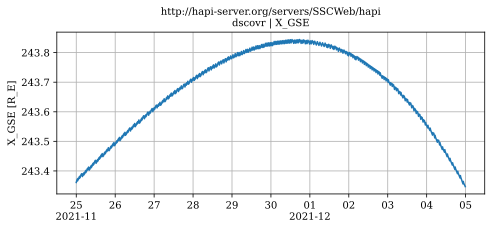

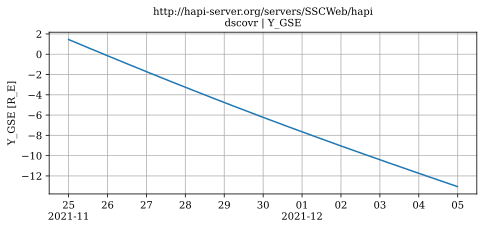

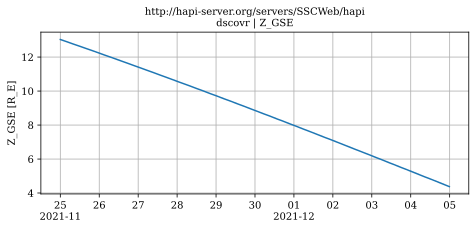

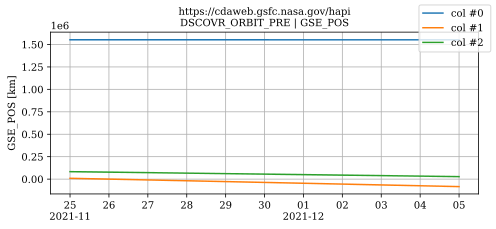

        X_GSE [R_E]  Y_GSE [R_E]  Z_GSE [R_E]  
SSCWeb: 243.63903103 1.46400240   13.05533682  	 on 2021-11-25T00:00:00.000000Z
CDAWeb: 243.36926843 1.43711310   13.03130715  	 on 2021-11-25T00:00:00.000Z


In [3]:
# Problem 01a solution

from hapiclient import hapi
from hapiplot import hapiplot

server     = 'http://hapi-server.org/servers/SSCWeb/hapi'
dataset    = 'dscovr'
parameters = 'X_GSE,Y_GSE,Z_GSE'
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
opts       = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

data_sscweb, meta_sscweb = hapi(server, dataset, parameters, start, stop)
hapiplot(data_sscweb, meta_sscweb)

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'DSCOVR_ORBIT_PRE'
parameters = 'GSE_POS'
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
opts       = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

data_cdaweb, meta_cdaweb = hapi(server, dataset, parameters, start, stop)
hapiplot(data_cdaweb, meta_cdaweb);

from hapiclient import hapitime2datetime

# After inspection of the metadata, we see that SSCWeb reports in R_E while CDAWeb in km.
# Convert CDAWeb data to R_E.
xyz_gse_cdaweb = list(data_cdaweb[0][1]/6371.)

# SSCWeb provides ephemeris as three separate parameters. Here we combine parameters into a list.
xyz_gse_sscweb = [data_sscweb['X_GSE'][1], data_sscweb['Y_GSE'][1], data_sscweb['Z_GSE'][1]]

time_cdaweb = data_cdaweb['Time'][0].decode()

# Convert from YYYY-DOY to YYYY-MM-DD date format
time_sscweb = hapitime2datetime([data_sscweb['Time'][0]])[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ')

# Time stamps are not idential. For a better comparison, use interpolation
# or find time values that exactly match between SSCWeb and CDAWeb data.
print('        {0:13s}{1:13s}{2:13s}'.format('X_GSE [R_E]', 'Y_GSE [R_E]', 'Z_GSE [R_E]'))
print('SSCWeb: {0:<13.8f}{1:<13.8f}{2:<13.8f}\t on {3:s}'.format(*xyz_gse_cdaweb, time_sscweb))
print('CDAWeb: {0:<13.8f}{1:<13.8f}{2:<13.8f}\t on {3:s}'.format(*xyz_gse_sscweb, time_cdaweb))

## <span style='background-color:yellow'>Problem 01b</span>

<br/>
<div style="background-color:yellow">
<p>
The following script has code for getting and plotting data from four spacecraft during the time interval considered above.
</p>    

<p>
<ol>
    <li>Modify the code so that the timestamps of the first and last elements in <code>data</code> are printed to the console.</li>
    <li>Modify the code so that the the first and last values in <code>data</code> for each parameter are printed to the console.</li>
</p>

In [ ]:
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-01T00:00:00Z'
opts       = {'logging': False, 'usecache': True, 'cachedir': './hapicache'}

# ACE Electron, Proton, and Alpha Monitor
# https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=AC_K0_EPM
if True:
    dataset    = 'AC_K0_EPM'
    parameters = 'H_lo,Electron_lo,Electron_hi'
    data, meta = hapi(server, dataset, parameters, start, stop, **opts)
    hapiplot(data, meta);

# POES N19 data: POES/MetOp: Particle Precipitation Data 
# https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=NOAA15_POES-SEM2_FLUXES-2SEC
if False:
    dataset    = 'THB_L2_SST@1'
    parameters = 'thb_psef_densityQ'
    data, meta = hapi(server, dataset, parameters, start, stop, **opts)
    hapiplot(data, meta);

# IMPACT (In-situ Measurements of Particles and CME Transients)/SIT data from the STEREO Ahead spacecraft.
# https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=STA_L1_SIT
if False:
    dataset    = 'STA_L1_SIT'
    parameters = 'H_Intensity'
    data, meta = hapi(server, dataset, parameters, start, stop, **opts)
    # Show png in notebook because many data points
    %config InlineBackend.figure_formats = ['png'] 
    hapiplot(data, meta);
    %config InlineBackend.figure_formats = ['svg'] 

# Wind 3dp, EESA HIGH electron omni directional energy spectra
# https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=WI_EHSP_3DP
if False:
    dataset    = 'WI_EHSP_3DP'
    parameters = 'FLUX'
    data, meta = hapi(server, dataset, parameters, start, stop, **opts)
    # Show png in notebook because many data points
    %config InlineBackend.figure_formats = ['png'] 
    hapiplot(data, meta);
    %config InlineBackend.figure_formats = ['svg'] 

In [7]:
# Problem 01b solution
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
opts       = {'logging': False, 'usecache': True, 'cachedir': './hapicache'}

dataset    = 'AC_K0_EPM'
parameters = 'H_lo,Electron_lo,Electron_hi'
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

print(data['Time'][0])
print(data['Time'][-1])
print(data[0])
print(data[-1])

b'2021-10-25T00:00:00.000Z'
b'2021-12-04T23:55:00.000Z'
(b'2021-10-25T00:00:00.000Z', 0.82300001, 1226.18994141, 29.54899979)
(b'2021-12-04T23:55:00.000Z', 3.15499997, 3002.64599609, 32.73799896)


Next up, a look into the underlying data structures in [HAPI_02.ipynb](HAPI_02.ipynb)
----